In [1]:
from phonecodes import phonecodes
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
import copy
import tqdm
import librosa
import seaborn as sns
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import textgrid
from scipy.spatial.distance import euclidean
import plotly.graph_objects as go
import pandas as pd
import jiwer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict
from transformers import AutoProcessor, AutoModelForCTC
from phonemizer.backend.espeak.wrapper import EspeakWrapper
import soundfile as sf

_ESPEAK_LIBRARY = r"C:\Program Files\eSpeak NG\libespeak-ng.dll"
EspeakWrapper.set_library(_ESPEAK_LIBRARY)
processor_P = AutoProcessor.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
model_P = AutoModelForCTC.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
from transformers import Wav2Vec2ForCTC
'''from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")'''

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-lv-60-espeak-cv-ft were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights 

'from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor\nprocessor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")\nmodel = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")'

In [2]:
output_dir = r"..\Nov10\wav2vec2_finetuned"
checkpoints = [f.path for f in os.scandir(output_dir) if f.is_dir() and 'checkpoint' in f.name]

# 获取最新的 checkpoint
latest_checkpoint = max(checkpoints, key=os.path.getmtime)
model_P = Wav2Vec2ForCTC.from_pretrained(latest_checkpoint)
model_P.eval()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projec

In [ ]:
arpabet_to_ipa={
    '<pad>': '<pad>',
    '<unk>': '<unk>',
    '<s>': '<s>',
    '</s>': '</s>',
    'AA0': 'ɑ',
    'AA1': 'ɑ',#ː
    'AA2': 'ɑ',
    'AE0': 'æ',
    'AE1': 'æ',
    'AE2': 'æ',
    'AH0': 'ə',
    'AH1': 'ʌ',
    'AH2': 'ʌ',
    'AO0': 'ɔ',
    'AO1': 'ɔ',#ː
    'AO2': 'ɔ',
    'AW0': 'aʊ',
    'AW1': 'aʊ',
    'AW2': 'aʊ',
    'AY0': 'aɪ',
    'AY1': 'aɪ',
    'AY2': 'aɪ',
    'B': 'b',
    'CH': 'tʃ',
    'D': 'd',
    'DH': 'ð',
    'EH0': 'ɛ',
    'EH1': 'ɛ',
    'EH2': 'ɛ',
    'ER0': 'ɚ',
    'ER1': 'ɚ',
    'ER2': 'ɚ',
    'EY0': 'eɪ',
    'EY1': 'eɪ',
    'EY2': 'eɪ',
    'F': 'f',
    'G': 'ɡ',
    'HH': 'h',
    'IH0': 'ɪ',
    'IH1': 'ɪ',
    'IH2': 'ɪ',
    'IY0': 'i',
    'IY1': 'i',#ː
    'IY2': 'i',
    'JH': 'dʒ',
    'K': 'k',
    'L': 'l',
    'M': 'm',
    'N': 'n',
    'NG': 'ŋ',
    'OW0': 'oʊ',
    'OW1': 'oʊ',
    'OW2': 'oʊ',
    'OY0': 'ɔɪ',
    'OY1': 'ɔɪ',
    'OY2': 'ɔɪ',
    'P': 'p',
    'R': 'ɹ',
    'S': 's',
    'SH': 'ʃ',
    'T': 't',
    'TH': 'θ',
    'UH0': 'ʊ',
    'UH1': 'ʊ',
    'UH2': 'ʊ',
#    'UW': 'uː',
    'UW0': 'u',
    'UW1': 'u',#ː
    'UW2': 'u',
    'V': 'v',
    'W': 'w',
    'Y': 'j',
    'Z': 'z',
    'ZH': 'ʒ',
}

def get_pathset(paths):
    return [os.path.join(dir, each_file) for dir, mid, files in os.walk(paths) for each_file in files if each_file.endswith(".wav")]

def CTC_index(processor,outind):
    meaningful_ids = []
    meaningful_indices = []
    previous_id = -1  
    blank_token_id = processor.tokenizer.pad_token_id  
    for i, token_id in enumerate(outind[0]):  
        if token_id != previous_id and token_id != blank_token_id:
            meaningful_ids.append(token_id.item())  
            meaningful_indices.append(i)  
        previous_id = token_id
    return meaningful_indices

def get_training_paths(TrainingTalkerID,all_path):
    path_list=[]
    TalkerID=[]
    for each_ID in TrainingTalkerID.split(", "):
        if each_ID[:3]=="CMN":
            TalkerID.append(f"ALL_{each_ID[-3:]}_M_CMN_ENG_HT1")
        else:
            TalkerID.append(f"ALL_{each_ID[-3:]}_M_ENG_ENG_HT1")
    
    for each_path in TalkerID:
        for i in all_path:
            if each_path in i:
                path_list.append(i)
                break
    
    return path_list

def align_sequences(seq1, seq2):
    len1, len2 = len(seq1), len(seq2)
    dp = np.zeros((len1 + 1, len2 + 1), dtype=int)

    for i in range(len1 + 1):
        dp[i][0] = i
    for j in range(len2 + 1):
        dp[0][j] = j

    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1,   
                           dp[i][j - 1] + 1,   
                           dp[i - 1][j - 1] + cost)       
    aligned_seq1, aligned_seq2 = [], []
    i, j = len1, len2
    while i > 0 or j > 0:
        if i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append('<pad>')  
            i -= 1
        elif j > 0 and dp[i][j] == dp[i][j - 1] + 1:
            aligned_seq1.append('<pad>')
            aligned_seq2.append(seq2[j - 1])
            j -= 1
        else:
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append(seq2[j - 1])
            i -= 1
            j -= 1
    return aligned_seq1[::-1], aligned_seq2[::-1]


def get_phonemes(word):
    cmu_dict = cmudict.dict()
    word = word.lower()
    return cmu_dict.get(word, ["<unk>"])

def align_sequences_with_index(seq1, seq2, index_list):
    len1, len2 = len(seq1), len(seq2)
    dp = np.zeros((len1 + 1, len2 + 1), dtype=int)


    for i in range(len1 + 1):
        dp[i][0] = i
    for j in range(len2 + 1):
        dp[0][j] = j


    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1,   
                           dp[i][j - 1] + 1,   
                           dp[i - 1][j - 1] + cost)


    aligned_seq1, aligned_seq2, aligned_index_list = [], [], []
    i, j = len1, len2
    while i > 0 or j > 0:
        if i > 0 and dp[i][j] == dp[i - 1][j] + 1:
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append('<pad>')
            aligned_index_list.append(-1) 
            #aligned_index_list.append(index_list[j - 1] + 1) 
            i -= 1
        elif j > 0 and dp[i][j] == dp[i][j - 1] + 1:
            aligned_seq1.append('<pad>')
            aligned_seq2.append(seq2[j - 1])
            aligned_index_list.append(-1)
            #aligned_index_list.append(index_list[j - 1]) 
            j -= 1
        else:
            aligned_seq1.append(seq1[i - 1])
            aligned_seq2.append(seq2[j - 1])
            aligned_index_list.append(index_list[j - 1])  
            i -= 1
            j -= 1
    return aligned_seq1[::-1], aligned_seq2[::-1], aligned_index_list[::-1]

    
def filter_none(aligned_seq1, aligned_index):
    aligned_index_c = []
    aligned_seq1_c = []
    if len(aligned_seq1)==len(aligned_index):
        for i in range(len(aligned_seq1)):
            if aligned_index[i]!=-1:
                aligned_index_c.append(aligned_index[i])
                aligned_seq1_c.append(aligned_seq1[i])

    return aligned_seq1_c, aligned_index_c
    

def build_exposure_set(paths, native_dict, set_list, model,processor):
    diphone_dict={}
    uniphone_dict={}
    english_phonemes = ['<pad>', '<unk>', '<s>', '</s>', 'ɑ', 'æ', 'ə', 'ʌ', 'ɔ', 'aʊ', 'aɪ', 'b', 'tʃ', 'd', 'ð', 'ɛ', 'ɚ', 'eɪ', 'f',
 'ɡ', 'h', 'ɪ', 'i', 'dʒ', 'k', 'l', 'm', 'n', 'ŋ', 'oʊ', 'ɔɪ', 'p', 'ɹ', 's', 'ʃ', 't', 'θ', 'ʊ', 'u', 'v', 'w',
 'j', 'z', 'ʒ']#['<pad>', '<s>', '</s>', '<unk>','p', 'b', 't', 'd', 'k', 'ɡ','m', 'n', 'ŋ', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'h', 'tʃ', 'dʒ', 'l', 'ɹ', 'w', 'j',"i","ɪ","ʊ","u","e","ɜ","æ","ʌ","ɑ","ɒ","eɪ","ɔɪ","oʊ","aɪ","aʊ"]
    english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
    english_phoneme_dict.values()
    for each_sentence in paths:
        tg = textgrid.TextGrid.fromFile(each_sentence[:-3]+"TextGrid")
        tg_sentence = [i for i in tg[0] if i.mark!=""]
        tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
        tg_sentence = [each for _,each in enumerate(tg_sentence) if _ in set_list]
        '''sentence16_end_time=tg_sentence[15].maxTime
        tg_sentence = [i for i in tg_sentence if i.maxTime<=sentence16_end_time]
        tg_word = [i for i in tg_word if i.maxTime<=sentence16_end_time]'''
        
        wave, sr = librosa.load(each_sentence)
        wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
        #wave_res = wave_res[:int(sentence16_end_time*16000)]
        for each_tg in tg_sentence:
            #each_phonemes =[arpabet_to_ipa[i.mark] for i in tg[-1] if each_tg.minTime<=i.minTime and each_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"]
            start=round(each_tg.minTime*16000)
            end=round(each_tg.maxTime*16000)
            input=processor(wave_res[start:end],sampling_rate=16000, return_tensors="pt").input_values
            input=input.to(device)
            model.to(device)
            with torch.no_grad():
                out_encoder1=model(input).logits
            selected=out_encoder1
            mask = np.ones(selected.shape[-1], dtype=bool)
            mask[list(english_phoneme_dict.values())] = False
            selected[:, :, mask] = 0
            outind=torch.argmax(selected,dim=-1).cpu().numpy()
            #outind=torch.argmax(out_encoder1,dim=-1).cpu().numpy()
            transcription = processor.batch_decode(outind)[0].split(" ")
            phonemeindex = CTC_index(processor,outind)
            out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().detach().numpy()
            '''aligned_seq1, aligned_seq2 ,phonemeindex= align_sequences_with_index(each_phonemes,transcription,phonemeindex)
            if phonemeindex[0]>phonemeindex[1]:
                phonemeindex[0]=0
            elif phonemeindex[0]==phonemeindex[1] and phonemeindex[1]>phonemeindex[2]:
                phonemeindex[0],phonemeindex[1]=0,1
            #aligned_seq1, aligned_seq2 = align_sequences(each_phonemes,transcription)
            if not len(aligned_seq1)==len(aligned_seq2)==len(phonemeindex):
                print(len(aligned_seq1),len(aligned_seq2),len(phonemeindex))
                print(aligned_seq1,"\n",aligned_seq2,"\n",phonemeindex)
                raise IndexError("length unmatch")'''
            
            for i in range(len(transcription)-1):#aligned_seq1transcription
                key = (transcription[i], transcription[i + 1])
                #key = transcription[i] + transcription[i + 1]
                if key not in diphone_dict:
                    diphone_dict[key] = []
                #try:
                diphone_dict[key].append(np.vstack((out_FE[phonemeindex[i]], out_FE[phonemeindex[i + 1]])))
 
                #except:
                    #print(each_tg)
                    #print(aligned_seq1)
                    #print(aligned_seq2)
                    #print(transcription)
                    #print(phonemeindex)
                    #print(key)
                    #out_dict[key].append(np.vstack((out_FE[phonemeindex[i]], out_FE[phonemeindex[i]])))
            for i in range(len(transcription)):
                if transcription[i] not in uniphone_dict:
                    uniphone_dict[transcription[i]]=[]
                uniphone_dict[transcription[i]].append(out_FE[phonemeindex[i]])
            '''for i in range(len(transcription)-1):
                key = transcription[i] + transcription[i + 1]
                if key not in native_dict:
                    native_dict[key] = []
                native_dict[key].append(np.vstack((out_FE[phonemeindex[i]], out_FE[phonemeindex[i + 1]])))'''
        torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    return diphone_dict,uniphone_dict#native_dict
    #'..\\data\\raw\\ALL_CMN_ENG_HT1\\ALL_032_M_CMN_ENG_HT1.wav'
    
    
def get_test_list(file_path,key_word,sentenceID,model,processor):
    english_phonemes = ['<pad>', '<unk>', '<s>', '</s>', 'ɑ', 'æ', 'ə', 'ʌ', 'ɔ', 'aʊ', 'aɪ', 'b', 'tʃ', 'd', 'ð', 'ɛ', 'ɚ', 'eɪ', 'f',
 'ɡ', 'h', 'ɪ', 'i', 'dʒ', 'k', 'l', 'm', 'n', 'ŋ', 'oʊ', 'ɔɪ', 'p', 'ɹ', 's', 'ʃ', 't', 'θ', 'ʊ', 'u', 'v', 'w',
 'j', 'z', 'ʒ']#['<pad>', '<s>', '</s>', '<unk>','p', 'b', 't', 'd', 'k', 'ɡ','m', 'n', 'ŋ', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'h', 'tʃ', 'dʒ', 'l', 'ɹ', 'w', 'j',"i","ɪ","ʊ","u","e","ɜ","æ","ʌ","ɑ","ɒ","eɪ","ɔɪ","oʊ","aɪ","aʊ"]
    english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
    sentenceID=int(sentenceID[-3:])-1
    #file_path= f'..\\data\\raw\\ALL_CMN_ENG_HT1\\{file_path[:-5]}.wav'
    
    tg = textgrid.TextGrid.fromFile(file_path[:-3]+"TextGrid")
    tg_sentence=[]
    for i in tg[0][1:]:
        if i.mark=="":
            tg_sentence[-1].maxTime=i.maxTime
        else:
            tg_sentence.append(i)
    tg_sentence = tg_sentence[sentenceID]
    
    tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
    
    wave, sr = librosa.load(file_path)
    wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
    

    for each_word_tg in tg_word:
        if each_word_tg.minTime >= tg_sentence.minTime and each_word_tg.maxTime <= tg_sentence.maxTime:
            #print(each_word_tg.mark.lower(),key_word)
            if each_word_tg.mark.lower()==key_word:
                start=each_word_tg.minTime
                end=each_word_tg.maxTime
                break
                #print("start:",start,"end:",end)
    #word_length=len(wave_res)/16000
    out_list=[]
    each_phonemes =[arpabet_to_ipa[i.mark] for i in tg[-1] if each_word_tg.minTime<=i.minTime and each_word_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"]
    sentence_total_length=tg_sentence.maxTime-tg_sentence.minTime
    word_cut_start=start-tg_sentence.minTime
    word_cut_end=end-tg_sentence.minTime
    
    input=processor(wave_res[int(tg_sentence.minTime*16000):round(tg_sentence.maxTime*16000)], sampling_rate=16000, return_tensors="pt").input_values.to(device)
    with torch.no_grad():
        out_encoder=model(input.to(device)).logits
        out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().numpy()
    
    word_start=round(out_encoder.shape[1]*word_cut_start/sentence_total_length)
    word_end=round(out_encoder.shape[1]*word_cut_end/sentence_total_length)
    
    selected=out_encoder[:,word_start:word_end,:]
    mask = np.ones(selected.shape[-1], dtype=bool)
    mask[list(english_phoneme_dict.values())] = False
    selected[:, :, mask] = 0
    outind=torch.argmax(selected,dim=-1).cpu().numpy()
    phonemeindex = CTC_index(processor,outind)
    transcription = processor_P.batch_decode(outind)[0].split(" ")
    #standrad_phonemes=[arpabet_to_ipa[i] for i in get_phonemes(key_word)[0]]
    aligned_seq1, aligned_seq2, phonemeindex_= align_sequences_with_index(each_phonemes,transcription,phonemeindex)
    #aligned_seq1 ,phonemeindex_ =  filter_none(aligned_seq1, phonemeindex_)
    
    if len(phonemeindex_)<2:
        each_FE = out_FE[word_start:,:]
        '''each_FE = out_FE[word_start:,:]
        selected=out_encoder[:,word_start:,:]
        mask = np.ones(selected.shape[-1], dtype=bool)
        mask[list(english_phoneme_dict.values())] = False
        selected[:, :, mask] = 0
        outind=torch.argmax(selected,dim=-1).cpu().numpy()
        phonemeindex = CTC_index(processor,outind)
        transcription = processor_P.batch_decode(outind)[0].split(" ")'''
        
        diphone_key = tuple(aligned_seq1[0])
        out_list.append((diphone_key, each_FE[phonemeindex_[0]]))#np.vstack((each_FE[phonemeindex[0]], each_FE[phonemeindex[0]]))))

    else:
        each_FE = out_FE[word_start:word_end,:]
        for i in range(len(aligned_seq1)-1):
            diphone_key=()
            if aligned_seq1[i]== aligned_seq2[i] and aligned_seq1[i+1]== aligned_seq2[i+1]:
                
                if phonemeindex_[i]!=-1 and phonemeindex_[i+1]!=-1 :#and each_FE[phonemeindex_[i]].ravel().shape==(512,) and each_FE[phonemeindex_[i+1]].ravel().shape==(512,)
                    diphone_key = (aligned_seq1[i] , aligned_seq1[i + 1])
                    diphone_vector=np.vstack((each_FE[phonemeindex_[i]], each_FE[phonemeindex_[i + 1]]))
                    out_list.append((diphone_key,diphone_vector))

                    
                elif phonemeindex_[i]!=-1 and phonemeindex_[i+1]==-1:
                    diphone_key = tuple([aligned_seq1[i]])
                    out_list.append((diphone_key, each_FE[phonemeindex_[i]]))
                    
                elif phonemeindex_[i]==-1 and phonemeindex_[i+1]!=-1:
                    diphone_key = tuple([aligned_seq1[i+1]])
                    out_list.append((diphone_key, each_FE[phonemeindex_[i+1]]))
                    
                else:
                    continue
                
            elif aligned_seq1[i]== aligned_seq2[i] and phonemeindex_[i]!=-1:
                diphone_key = tuple([aligned_seq1[i]])
                out_list.append((diphone_key, each_FE[phonemeindex_[i]]))
                
            elif aligned_seq1[i+1]== aligned_seq2[i+1] and phonemeindex_[i+1]!=-1:
                diphone_key = tuple([aligned_seq1[i+1]])
                out_list.append((diphone_key, each_FE[phonemeindex_[i+1]]))
                
            else:
                continue
    torch.cuda.empty_cache()
    return out_list


In [132]:
ppp=tuple(['aɪ'])
ppp

('aɪ',)

In [4]:
import warnings
def sim_measure(df, model, processor):
    sim_mean_max_list,sim_mean_std_list,sim_mean_mean_list,isincluded_list,diphone_count =[], [], [], [], []
    confusion_matrix_list, wav2vec_acc_list=[],[]
    X_list=[]
    Y_list=[]
    english_phonemes = ['<pad>', '<unk>', '<s>', '</s>', 'ɑ', 'æ', 'ə', 'ʌ', 'ɔ', 'aʊ', 'aɪ', 'b', 'tʃ', 'd', 'ð', 'ɛ', 'ɚ', 'eɪ', 'f',
 'ɡ', 'h', 'ɪ', 'i', 'dʒ', 'k', 'l', 'm', 'n', 'ŋ', 'oʊ', 'ɔɪ', 'p', 'ɹ', 's', 'ʃ', 't', 'θ', 'ʊ', 'u', 'v', 'w',
 'j', 'z', 'ʒ']#['<pad>', '<s>', '</s>', '<unk>','p', 'b', 't', 'd', 'k', 'ɡ','m', 'n', 'ŋ', 'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'h', 'tʃ', 'dʒ', 'l', 'ɹ', 'w', 'j',"i","ɪ","ʊ","u","e","ɜ","æ","ʌ","ɑ","ɒ","eɪ","ɔɪ","oʊ","aɪ","aʊ"]
    
    english_phoneme_dict = {k: v for k, v in processor_P.tokenizer.get_vocab().items() if k in english_phonemes}
    
    phoneme_vocab = {phoneme: idx for idx, phoneme in enumerate(english_phonemes)}
    
    
    
    train_set_dict={}
    test_word_dict={}
    test_matrix_dict={}

    for each_ in tqdm.tqdm(df.values):

        filename_loc=df.columns.get_loc("Filename")
        keyword_loc=df.columns.get_loc("Keyword")
        training_talker_loc=df.columns.get_loc("TrainingTalkerID")
        
        all_path=get_pathset(r"..\data\raw")
        #all_ENG_ENG_pathset=[s.replace("raw_L1", "raw") for s in get_pathset(r"..\data\raw_L1")]
        
        set1_list=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]
        set2_list=[17,18,19,20,21,22,24,25,26,27,28,29,30,31,37,40]
        if each_[df.columns.get_loc("TrainingTestSet")] == "set2,set1":
            train_set=set2_list
            test_set=set1_list
        else:
            train_set=set1_list
            test_set=set2_list
        
        #print(each_[filename_loc])
        test_file = [each for each in all_path if os.path.split(each_[filename_loc])[-1][:-5] in each]
        #print(test_file)
        key_word = each_[keyword_loc] #string
        TrainingTalkerID = each_[training_talker_loc] #list of string
        sentenceID = each_[df.columns.get_loc("SentenceID")]
        training_files_path=get_training_paths(TrainingTalkerID,all_path)
        
        #if training_files_path[0] in all_ENG_ENG_pathset:
        #    training_dict=copy.deepcopy(all_eng_dict)
        #else:
        
        if TrainingTalkerID not in train_set_dict:
            train_set_dict[TrainingTalkerID]={}
            
        if each_[df.columns.get_loc("TrainingTestSet")] not in train_set_dict[TrainingTalkerID]:
            training_dict_di, training_dict_uni=build_exposure_set(training_files_path, {}, train_set, model, processor)#copy.deepcopy(all_eng_dict)
            train_set_dict[TrainingTalkerID][each_[df.columns.get_loc("TrainingTestSet")]]=(copy.deepcopy(training_dict_di),copy.deepcopy(training_dict_uni))
        else:
            training_dict_di, training_dict_uni=train_set_dict[TrainingTalkerID][each_[df.columns.get_loc("TrainingTestSet")]]
        
        
        
        if test_file[0] not in test_word_dict:
            test_word_dict[test_file[0]]={}
        if sentenceID not in test_word_dict[test_file[0]]:
            test_word_dict[test_file[0]][sentenceID]={}
        if key_word not in test_word_dict[test_file[0]][sentenceID]:
            test_list = get_test_list(test_file[0], key_word, sentenceID, model, processor)
            test_word_dict[test_file[0]][sentenceID][key_word]=copy.deepcopy(test_list)
        else:
            test_list=test_word_dict[test_file[0]][sentenceID][key_word]
        
        if test_file[0] not in test_matrix_dict:
            test_matrix_dict[test_file[0]]={}
        if sentenceID not in test_matrix_dict[test_file[0]]:
            test_matrix_dict[test_file[0]][sentenceID]={}
        if key_word not in test_matrix_dict[test_file[0]][sentenceID]:
            
            tg = textgrid.TextGrid.fromFile(test_file[0][:-3]+"TextGrid")
            tg_sentence = [i for i in tg[0] if i.mark!=""][int(sentenceID[-3:])-1]
            tg_word = [i for i in tg[1] if tg_sentence.minTime<=i.minTime and tg_sentence.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark.lower()==key_word][0]
            
            each_word_phonemes =[arpabet_to_ipa[i.mark] for i in tg[-1] if tg_word.minTime<=i.minTime and tg_word.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"]
            
            sentence_total_length=tg_sentence.maxTime-tg_sentence.minTime
            word_cut_start=tg_word.minTime-tg_sentence.minTime
            word_cut_end=tg_word.maxTime-tg_sentence.minTime
            wave, sr = librosa.load(test_file[0])
            wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
            input=processor(wave_res[int(tg_sentence.minTime*16000):round(tg_sentence.maxTime*16000)], sampling_rate=16000, return_tensors="pt").input_values.to(device)
            with torch.no_grad():
                out_encoder=model(input.to(device)).logits
                
            word_start=round(out_encoder.shape[1]*word_cut_start/sentence_total_length)
            word_end=round(out_encoder.shape[1]*word_cut_end/sentence_total_length)
            selected=out_encoder[:,word_start:word_end,:]
            mask = np.ones(selected.shape[-1], dtype=bool)
            mask[list(english_phoneme_dict.values())] = False
            selected[:, :, mask] = 0
            outind=torch.argmax(selected,dim=-1).cpu().numpy()
            #phonemeindex = CTC_index(processor,outind)
            transcription = processor_P.batch_decode(outind)[0].split(" ")
            X_=each_word_phonemes
            Y_=transcription
            #print(each_word_phonemes,"\n",transcription)
            aligned_seq1, aligned_seq2 = align_sequences(each_word_phonemes,transcription)
            
            N=len(list(phoneme_vocab.keys()))
            confusion_matrix = np.zeros((N, N), dtype=int)
            #print(confusion_matrix.shape)
            for true_phoneme, predicted_phoneme in zip(aligned_seq1, aligned_seq2):
                if predicted_phoneme in english_phonemes[:4]:
                    true_idx = phoneme_vocab[true_phoneme]
                    predicted_idx = phoneme_vocab[true_phoneme]
                else:
                    true_idx = phoneme_vocab[true_phoneme]
                    predicted_idx = phoneme_vocab[predicted_phoneme]
                #print(true_idx, predicted_idx)
                confusion_matrix[predicted_idx,true_idx] += 1
            
            
            phoneme_error = [1 if aligned_seq1[_]==aligned_seq2[_] else 0 for _ in range(len(aligned_seq1))]
            #print(np.array(list(english_phoneme_dict.values())))
            #confusion_matrix = #out_encoder[:,word_start:word_end,list(english_phoneme_dict.values())].cpu().numpy()
            test_matrix_dict[test_file[0]][sentenceID][key_word]=(X_,Y_,phoneme_error, confusion_matrix)
        else:
            X_=test_matrix_dict[test_file[0]][sentenceID][key_word][0]
            Y_=test_matrix_dict[test_file[0]][sentenceID][key_word][1]
            phoneme_error = test_matrix_dict[test_file[0]][sentenceID][key_word][2]
            confusion_matrix = copy.deepcopy(test_matrix_dict[test_file[0]][sentenceID][key_word][3])
        
    #return test_word_dict
        # word level, list
        sim_max=[]
        sim_std=[]
        sim_mean=[]
        isincluded=[]
        #sim_count=[]
        for _, each_diphone in enumerate(test_list):
            sims=[]
            #print(each_diphone)
            if len(each_diphone[0])==1:
                if each_diphone[0][0] in training_dict_uni.keys():
                    for each_vec in training_dict_uni[each_diphone[0][0]]:
                        current_test_uni=each_diphone[1].ravel()
                        current_test_uni=np.hstack((current_test_uni,current_test_uni))
                        current_e_uni=each_vec.ravel()
                        current_e_uni=np.hstack((current_e_uni,current_e_uni))
                        sim=np.exp(-0.1*euclidean(current_test_uni,current_e_uni))
                        sims.append(sim)
                    isincluded.append(1)
                        
                else:
                    sims.append(0)
                    isincluded.append(0)
                    warnings.warn("Uniphone unmatch: "+each_diphone[0][0], UserWarning)
                    #raise Warning("Uniphone unmatch"+each_diphone[0][0])
                
                sim_max.append(np.max(sims))
                sim_std.append(np.std(sims))
                sim_mean.append(np.mean(sims))
            elif len(each_diphone[0])==2:
                #print(each_diphone[0])
                if each_diphone[0] in training_dict_di.keys():
                    for each_vec in training_dict_di[each_diphone[0]]:
                        sim=np.exp(-0.1*euclidean(each_diphone[1].ravel(),each_vec.ravel()))
                        sims.append(sim)
                    isincluded.append(1)
                
                else:
                    
                    isincluded.append(0)
                    if each_diphone[0][0] in training_dict_uni.keys() and each_diphone[0][1] in training_dict_uni.keys():
                        for each_vec in training_dict_uni[each_diphone[0][0]]:
                            current_test_uni=each_diphone[1].ravel()[:512]
                            current_test_uni=np.hstack((current_test_uni,np.zeros_like(current_test_uni)))
                            current_e_uni=each_vec.ravel()
                            current_e_uni=np.hstack((current_e_uni,np.zeros_like(current_e_uni)))
                            d=euclidean(current_test_uni,current_e_uni)
                            sims.append(np.exp(-0.1*d))
                        for each_vec in training_dict_uni[each_diphone[0][1]]:
                            current_test_uni=each_diphone[1].ravel()[512:]
                            current_test_uni=np.hstack((current_test_uni,np.zeros_like(current_test_uni)))
                            current_e_uni=each_vec.ravel()
                            current_e_uni=np.hstack((current_e_uni,np.zeros_like(current_e_uni)))
                            sims.append(np.exp(-0.1*euclidean(current_test_uni,current_e_uni)))
                    elif each_diphone[0][0] in training_dict_uni.keys():
                        for each_vec in training_dict_uni[each_diphone[0][0]]:
                            current_test_uni=each_diphone[1].ravel()[:512]
                            current_test_uni=np.hstack((current_test_uni,np.zeros_like(current_test_uni)))
                            current_e_uni=each_vec.ravel()
                            current_e_uni=np.hstack((current_e_uni,np.zeros_like(current_e_uni)))
                            d=euclidean(current_test_uni,current_e_uni)
                            sims.append(np.exp(-0.1*d))
                    elif each_diphone[0][1] in training_dict_uni.keys():
                        for each_vec in training_dict_uni[each_diphone[0][1]]:
                            current_test_uni=each_diphone[1].ravel()[512:]
                            current_test_uni=np.hstack((current_test_uni,np.zeros_like(current_test_uni)))
                            current_e_uni=each_vec.ravel()
                            current_e_uni=np.hstack((current_e_uni,np.zeros_like(current_e_uni)))
                            try:
                                sims.append(np.exp(-0.1*euclidean(current_test_uni,current_e_uni)))
                            except:
                                print(each_diphone[0],each_diphone[1].shape)
                                print(current_test_uni.shape,current_e_uni.shape)
                    else:
                        sims.append(0)
                    
                sim_max.append(np.max(sims))
                sim_std.append(np.std(sims))
                sim_mean.append(np.mean(sims))
            else:
                sims.append(0)
                isincluded.append(0)
                sim_max.append(np.max(sims))
                sim_std.append(np.std(sims))
                sim_mean.append(np.mean(sims))
            
        if len(isincluded)==0:
            #print(each_diphone)
            sims.append(0)
            isincluded.append(0)
            sim_max.append(np.max(sims))
            sim_std.append(np.std(sims))
            sim_mean.append(np.mean(sims))
        
        sim_mean_max=np.mean(sim_max)
        sim_mean_std=np.mean(sim_std)
        sim_mean_mean=np.mean(sim_mean)
        
        X_list.append(X_)
        Y_list.append(Y_)
        wav2vec_acc_list.append(np.count_nonzero(phoneme_error)/len(phoneme_error))
        confusion_matrix_list.append(confusion_matrix)
        sim_mean_max_list.append(sim_mean_max)
        sim_mean_std_list.append(sim_mean_std)
        sim_mean_mean_list.append(sim_mean_mean)
        isincluded_list.append(np.count_nonzero(isincluded)/len(isincluded))
        diphone_count.append(len(isincluded))
        
    return sim_mean_max_list,sim_mean_std_list,sim_mean_mean_list,isincluded_list,diphone_count,X_list,Y_list,wav2vec_acc_list, confusion_matrix_list



In [5]:
human_result_path=r"..\data\test.xlsx"
human_result = pd.read_excel(human_result_path)
human_result_1a=human_result[human_result["Experiment"]=="1a"]

In [58]:
human_result_1a["Keyword"][1123]

'ripe'

In [141]:
a=[[1,2,3],[4,5,6]]
np.zeros_like(a)

array([[0, 0, 0],
       [0, 0, 0]])

In [134]:
test_word_dict=sim_measure(human_result_1a,model_P, processor_P)

100%|██████████| 16477/16477 [06:07<00:00, 44.88it/s] 


In [6]:
sim_mean_max_list,sim_mean_std_list,sim_mean_mean_list,isincluded_list,diphone_count,X_list,Y_list,wav2vec_acc_list, confusion_matrix_list=sim_measure(human_result_1a,model_P, processor_P)


 18%|█▊        | 3017/16477 [02:37<00:41, 326.65it/s]C:\Users\Alex\AppData\Local\Temp\ipykernel_328848\2310897155.py:155: UserWarning: Uniphone unmatch: dʒ
  warnings.warn("Uniphone unmatch: "+each_diphone[0][0], UserWarning)
 26%|██▌       | 4296/16477 [02:45<00:30, 402.20it/s]C:\Users\Alex\AppData\Local\Temp\ipykernel_328848\2310897155.py:155: UserWarning: Uniphone unmatch: ɔ
  warnings.warn("Uniphone unmatch: "+each_diphone[0][0], UserWarning)
100%|██████████| 16477/16477 [06:12<00:00, 44.18it/s] 


In [7]:
human_result_1a["sim_mean_max"]=sim_mean_max_list
human_result_1a["sim_mean_std"]=sim_mean_std_list
human_result_1a["sim_mean_mean"] = sim_mean_mean_list
human_result_1a["diphone_overlapped_rate"]=isincluded_list
human_result_1a["NumDiphone_word"]=diphone_count
human_result_1a["wav2vec_acc"]=wav2vec_acc_list
human_result_1a["x"]=X_list
human_result_1a["y"]=Y_list
human_result_1a.to_excel('similarities_b2.xlsx')


C:\Users\Alex\AppData\Local\Temp\ipykernel_328848\2136751244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_result_1a["sim_mean_max"]=sim_mean_max_list
C:\Users\Alex\AppData\Local\Temp\ipykernel_328848\2136751244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_result_1a["sim_mean_std"]=sim_mean_std_list
C:\Users\Alex\AppData\Local\Temp\ipykernel_328848\2136751244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

<Figure size 1200x800 with 0 Axes>

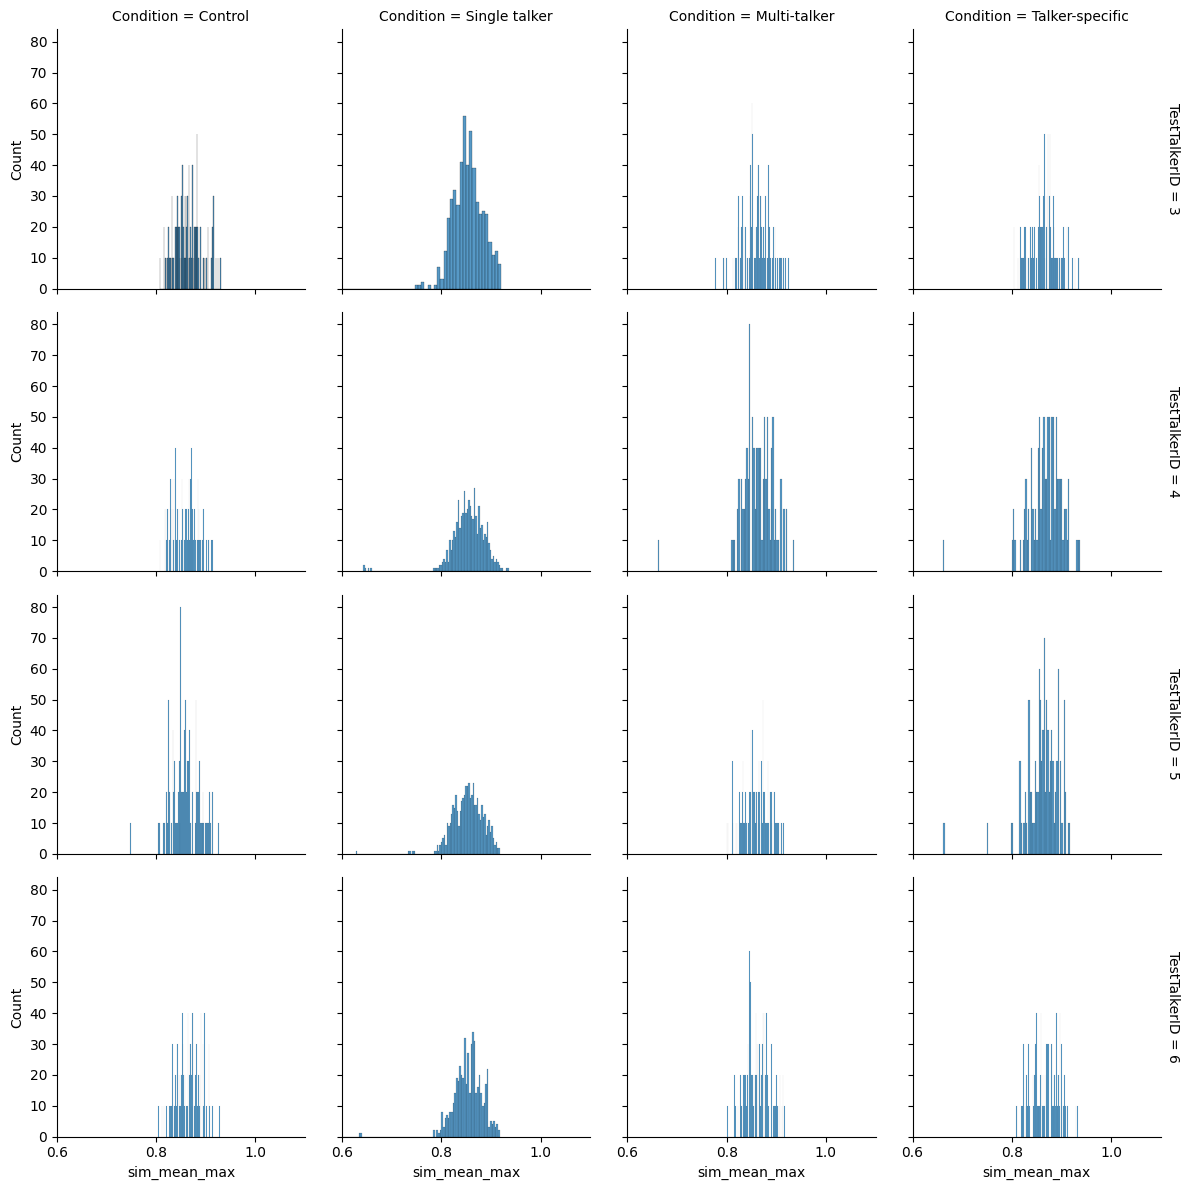

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
d_sim = pd.read_excel("./similarities_b1.xlsx")
d_sim = d_sim[(d_sim['Experiment'] == '1a') & (d_sim['PartOfExp'] == 'test')]
d_sim = d_sim.rename(columns={'TrainingTalkerID': 'ExposureTalkerID'})
d_sim['ExposureTalkerID'] = d_sim.apply(
    lambda row: row['ExposureTalkerID'] if row['Condition2'] == 'Single talker' 
    else f"Exposure for {row['Condition2']} - TestTalkerID {row['TestTalkerID']}" if row['Condition2'] in ['Multi-talker', 'Talker-specific'] 
    else f"Exposure for {row['Condition2']}",
    axis=1
)
d_sim['KeywordID'] = pd.factorize(d_sim['Keyword'])[0] + 1
d_sim['ProportionDiphoneOverlap'] = d_sim['diphone_overlapped_rate'] #/ d_sim['NumDiphone_word']
id_columns = ['WorkerID', 'ExposureTalkerID', 'TestTalkerID', 'SentenceID', 'KeywordID']
d_sim[id_columns] = d_sim[id_columns].astype('category')
d_sim['Condition'] = pd.Categorical(d_sim['Condition2'], categories=['Control', 'Single talker', 'Multi-talker', 'Talker-specific'], ordered=True)

grouped_sim = d_sim.groupby(['Condition', 'ExposureTalkerID', 'TestTalkerID', 'SentenceID', 'KeywordID']).agg(
    sim_mean_max=('sim_mean_max', 'mean')
).reset_index()

single_talker_data = grouped_sim[grouped_sim['Condition'] == 'Single talker']
control_data = grouped_sim[grouped_sim['Condition'] == 'Control']
multi_talker_data = grouped_sim[grouped_sim['Condition'] == 'Multi-talker']
talker_specific_data = grouped_sim[grouped_sim['Condition'] == 'Talker-specific']
control_data_expanded = pd.concat([control_data] * 10, ignore_index=True)
multi_talker_data_expanded = pd.concat([multi_talker_data] * 10, ignore_index=True)
talker_specific_data_expanded = pd.concat([talker_specific_data] * 10, ignore_index=True)
balanced_grouped_sim = pd.concat([single_talker_data, control_data_expanded, multi_talker_data_expanded, talker_specific_data_expanded], ignore_index=True)


plt.figure(figsize=(12, 8))
g = sns.FacetGrid(balanced_grouped_sim, row='TestTalkerID', col='Condition', margin_titles=True, sharex=True)
g.map(sns.histplot, 'sim_mean_max', bins=100)
g.set(xlim=(0.6, 1.1))
#g.set(ylim=(-0.1,15))
plt.tight_layout()
plt.show()



In [160]:
balanced_grouped_sim.columns

Index(['Condition', 'ExposureTalkerID', 'TestTalkerID', 'SentenceID',
       'KeywordID', 'sim_mean_max'],
      dtype='object')

In [162]:
balanced_grouped_sim["sim_mean_max"].value_counts()

0.860030    11
0.878078    11
0.858697    11
0.891356    11
0.869771    11
            ..
0.835426     1
0.848921     1
0.811817     1
0.855781     1
0.823201     1
Name: sim_mean_max, Length: 3210, dtype: int64

In [10]:
d_sim.groupby('Condition').agg(
    {col: 'mean' for col in d_sim.columns if col.startswith('sim')}
).reset_index()


,Condition,sim_mean_max,sim_mean_std,sim_mean_mean
0,Control,0.861880,0.017882,0.824509
1,Single talker,0.853597,0.016170,0.828246
2,Multi-talker,0.861747,0.017659,0.825371
3,Talker-specific,0.865599,0.018785,0.835366


In [11]:
result = d_sim.pivot_table(
    index='Condition',
    columns='TestTalkerID',
    values=[col for col in d_sim.columns if col.startswith('diphone_overlapped_rate')],
    aggfunc='mean'
)

result.columns = [f'TestTalker_{col[1]}' for col in result.columns]#_{col[0]}
result = result.reset_index()
result


,Condition,TestTalker_3,TestTalker_4,TestTalker_5,TestTalker_6
0,Control,0.614910,0.625566,0.623905,0.623948
1,Single talker,0.556852,0.568867,0.570218,0.570485
2,Multi-talker,0.671868,0.654531,0.667799,0.655340
3,Talker-specific,0.569279,0.558414,0.563673,0.580906


In [183]:
print(d_sim.groupby('Condition2')['sim_mean_max'].describe())


                  count      mean       std       min       25%       50%  \
Condition2                                                                  
Control          4117.0  0.861880  0.026420  0.747352  0.842704  0.861603   
Multi-talker     4120.0  0.861747  0.028363  0.661072  0.845537  0.861583   
Single talker    4120.0  0.853597  0.035992  0.275727  0.835817  0.854656   
Talker-specific  4120.0  0.865599  0.031579  0.660993  0.848290  0.866341   

                      75%       max  
Condition2                           
Control          0.880770  0.929894  
Multi-talker     0.880113  0.935887  
Single talker    0.874341  0.935887  
Talker-specific  0.886208  0.937951  


In [186]:

print(d_sim.duplicated().sum())




0


In [197]:
def get_phonemes(word):
    cmu_dict = cmudict.dict()
    word = word.lower()
    return cmu_dict.get(word, ["<unk>"])
get_phonemes("lose")

[['L', 'UW1', 'Z']]

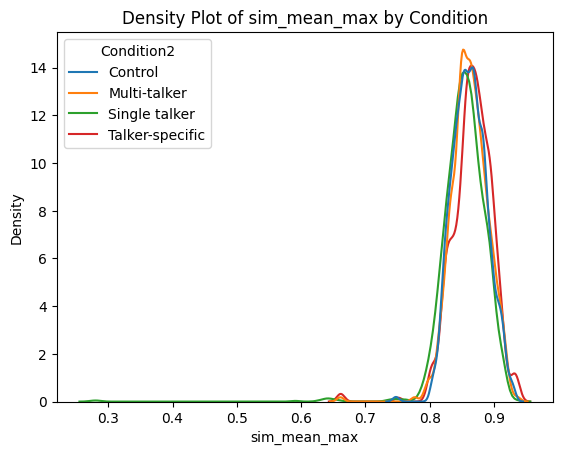

In [185]:

sns.kdeplot(data=d_sim, x="sim_mean_max", hue="Condition2", common_norm=False)
plt.title("Density Plot of sim_mean_max by Condition")
plt.xlabel("sim_mean_max")
plt.ylabel("Density")
plt.show()

In [177]:
len(set(human_result_1a["TrainingTalkerID"]))

135